# Deep Learning Solution Method with All-in-One Expectation Operator (PyTorch)

**Converted from TensorFlow to PyTorch**

This notebook implements the Euler residual minimization approach from Maliar, Maliar and Winant (2019) for solving a consumption-saving problem with occasionally binding borrowing constraints.

Key ideas:
- Parameterize decision rules with neural networks
- Use stochastic optimization (train on randomly sampled grid points)
- All-in-one expectation: use two independent random draws to eliminate correlation between residual terms

In [1]:
import torch
import torch.nn as nn
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm
import quantecon as qe

# Set device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Model 

The model is a standard, toy-RBC model. A household maximizes
$$V(Z,K)=u(c)+\beta \mathbb{E}[V(Z',K')],$$
subject to the budget constraint 
$$K'+C=ZK^{\alpha} + (1-\delta) K,$$
and $u(c)=\frac{c^{1-\gamma}}{1-\gamma}$. We are looking for a policy function $K'=\sigma(Z,K)$ that satisfies the Euler equation 
$$C^{-\gamma}=\beta\mathbb{E}[C^{-\gamma}(1+\alpha ZK^{'\alpha-1}-\delta)],$$
and with 
$$C=ZK^{\alpha} + (1-\delta) K-\sigma(Z,K);$$
and 
$$C'=Z'K^{',\alpha}+(1-\delta)K'-\sigma(Z',K').$$

## Model Parameters

In [2]:
# Model parameters

## Preferences
beta = 0.9 
gamma = 2.0 

## Firms
alpha = 1/3 
delta = 0.05 

## TFP 
sigma_Z = 0.001
rho_Z = 0.9


In [3]:
true_mean = np.exp(1/2 * sigma_Z**2 / (1 - rho_Z**2))

In [4]:
n_Z = 9
tauchen_result = qe.tauchen(n_Z, rho_Z, sigma_Z, mu=0, n_std=3)
log_Z_grid = tauchen_result.state_values  # log(Z) grid
Pi_Z = torch.tensor(tauchen_result.P, dtype=torch.float32, device=device)  # Transition matrix
Z_grid = torch.tensor(np.exp(log_Z_grid), dtype=torch.float32, device=device)  # Z grid in levels
Z_ergodic = torch.tensor(tauchen_result.stationary_distributions[0], dtype=torch.float32, device=device)  # Ergodic distribution
mu_Z = torch.sum(Z_ergodic * Z_grid).item()
print(mu_Z)

1.0000032186508179


In [5]:
def production_function(Z, K):
    """Cobb-Douglas production function"""
    return Z * K**alpha 

def coh_fun(Z, K):
    return production_function(Z, K) + (1 - delta) * K

def r_fun(Z, K):
    """Return the interest rate given Z and K"""
    return alpha * production_function(Z, K) / K - delta 

def c_fun(savings_rate, Z, K):
    """Consumption function given savings rate, TFP Z and capital K"""
    coh = coh_fun(Z, K)
    return (1 - savings_rate) * coh

## Stochastic Solution Domain

For AR(1) processes, the ergodic distribution has standard deviation $\sigma_z = \frac{\sigma}{\sqrt{1-\rho^2}}$

In [6]:
# Steady-state 
r = 1/beta - 1 
Z_ss = 1
K_ss = ((r + delta) / (alpha * Z_ss))**(1/(alpha-1))
Y_ss = K_ss**alpha
C_ss = Y_ss - delta * K_ss 
savings_rate_ss = K_ss / (Y_ss + (1 - delta) * K_ss)

# bounds for endogenous state variable
Kmin = K_ss * 0.5
Kmax = K_ss * 2.0
K_grid = np.linspace(Kmin, Kmax, 500)

# Normalization constant for Z in levels (std of Z_grid around mean of 1)
Z_std = np.std(np.exp(log_Z_grid))  # std of Z in levels

In [7]:
print(Kmin)
print(K_ss )
print(Kmax )

1.48798955633395
2.9759791126679
5.9519582253358


## Neural Network Definition


In [8]:
class DecisionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), # two inputs 
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1) # one output
        )
        ## Initialize with He uniform (similar to TensorFlow's he_uniform)
        #for layer in self.net:
        #    if isinstance(layer, nn.Linear):
        #        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        #        nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.net(x)

perceptron = DecisionNetwork().to(device)
print(perceptron)

DecisionNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [9]:
def policy_function(Z, K):
    """Decision rule: maps states to (savings_rate, h)"""
    
    # Normalize inputs to roughly [-1, 1] range
    Z_normalized = (Z-1.0) / Z_std
    #K_normalized = (K - K_ss) / K_ss
    K_normalized = 2.0 * (K - Kmin) / (Kmax - Kmin) - 1.0
    
    # Stack inputs: shape (n, 2)
    s = torch.stack([Z_normalized, K_normalized], dim=1)
    
    # Forward pass through network
    x = perceptron(s)  # (n, 1)
    
    # Savings rate in [0,1]
    savings_rate = torch.sigmoid(x[:, 0])
        
    return torch.clamp(savings_rate, max = 0.9999)

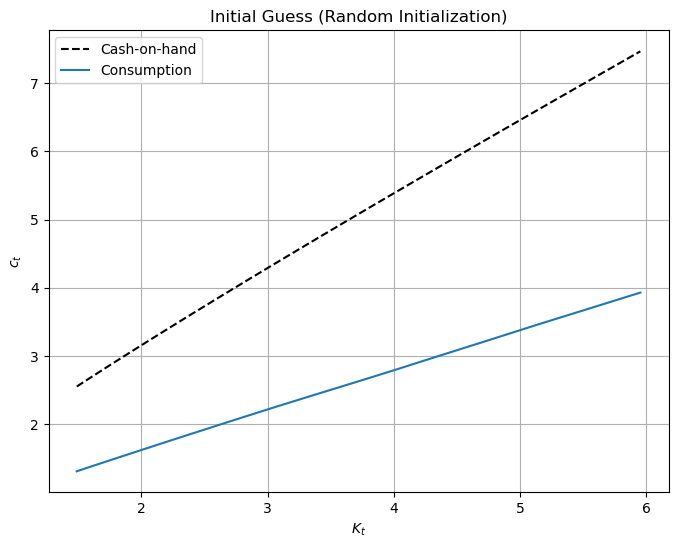

In [10]:
# Plot initial guess (random initialization)
with torch.no_grad():
    Kvec = torch.linspace(Kmin, Kmax, 100, device=device)
    ones = torch.ones_like(Kvec)  # Z = 1 (level value at steady state)
    savings_rate_vec = policy_function(ones, Kvec)
    consumption_vec = c_fun(savings_rate_vec, ones, Kvec)

plt.figure(figsize=(8, 6))
plt.plot(Kvec.cpu(), coh_fun(ones, Kvec).cpu(), linestyle='--', color='black', label='Cash-on-hand')
plt.plot(Kvec.cpu(), consumption_vec.cpu(), label='Consumption')
plt.xlabel("$K_t$")
plt.ylabel("$c_t$")
plt.title("Initial Guess (Random Initialization)")
plt.legend()
plt.grid()
plt.show()

In [11]:
def euler_residuals(Z, K, n_mc=64):
    """
    Euler residuals with Monte Carlo expectation over epsilon shocks.

    Assumes: log Z' = rho * log Z + eps,  eps ~ N(0, sigma_eps^2)
    (If you have a nonzero drift, add it below.)

    Args:
        iz: current index of TFP in the grid, shape (batch_size,)
        K: current capital, shape (batch_size,)
        n_mc: number of Monte Carlo draws per state

    Returns:
        R: Euler equation residual, shape (batch_size,)
    """
    # Current Z (levels) from grid and batch size
    n = K.shape[0]

    # Current decisions
    savings_rate = policy_function(Z, K)
    coh = coh_fun(Z, K)
    K_next = savings_rate * coh
    C = coh - K_next

    # LHS: u'(C)
    LHS = C**(-gamma)

    # ---- Monte Carlo expectation for RHS ----
    # Draw eps shocks: (batch_size, n_mc)
    eps = sigma_Z * torch.randn(n, n_mc, device=K.device, dtype=K.dtype)

    # Compute Z' in levels: Z' = exp(rho * log Z + eps)
    logZ = torch.log(Z).unsqueeze(1)            # (batch_size, 1)
    logZ_next = rho_Z * logZ + eps                # (batch_size, n_mc)
    Z_next = torch.exp(logZ_next)               # (batch_size, n_mc)

    # Expand K_next across MC draws
    K_next_mc = K_next.unsqueeze(1).expand(-1, n_mc)  # (batch_size, n_mc)

    # Flatten to evaluate functions in one shot
    Z_next_flat = Z_next.reshape(-1)            # (batch_size*n_mc,)
    K_next_flat = K_next_mc.reshape(-1)         # (batch_size*n_mc,)

    # Next-period policy and consumption
    savings_rate_next = policy_function(Z_next_flat, K_next_flat)
    C_next = c_fun(savings_rate_next, Z_next_flat, K_next_flat)

    # Future returns and marginal utility
    r_next = r_fun(Z_next_flat, K_next_flat)
    MU_next = C_next**(-gamma)

    # Monte Carlo estimate of E[(1+r') u'(C')]
    term = ((1.0 + r_next) * MU_next).reshape(n, n_mc)  # (batch_size, n_mc)
    E_term = term.mean(dim=1)                            # (batch_size,)

    # RHS: beta * E[...]
    RHS = beta * E_term

    # Residual
    R = RHS / LHS - 1.0
    return R


## Objective Function 

In [12]:
def sample_Z_ergodic(n, rho, sigma_eps, *, device=None, dtype=torch.float32):
    if not (-1.0 < rho < 1.0):
        raise ValueError("Need |rho| < 1 for a stationary (ergodic) distribution.")
    device = device or torch.device("cpu")
    rho = torch.as_tensor(rho, device=device, dtype=dtype)
    sigma_eps = torch.as_tensor(sigma_eps, device=device, dtype=dtype)

    sigma_x = sigma_eps / torch.sqrt(1.0 - rho**2)          # std of log Z in stationarity
    x = sigma_x * torch.randn(n, device=device, dtype=dtype) # mean 0
    Z = torch.exp(x)
    return Z

def objective_function(n):
    """
    Objective function: minimize E[R²] where R is the Euler residual.
    
    Uses Tauchen quadrature for computing expectations (no Monte Carlo noise).
    
    Args:
        n: Number of state samples (Z, K)
    
    Returns:
        loss: Mean squared Euler residual
    """
    # Sample current states from ergodic distribution
    Z = sample_Z_ergodic(n, rho_Z, sigma_Z, device=device)
    K = torch.rand(n, device=device) * (Kmax - Kmin) + Kmin

    # Compute Euler residual with Tauchen quadrature
    R = euler_residuals(Z, K)
    
    # Minimize squared residuals
    return torch.mean(R**2)

## Test the Objective

In [13]:
n = 256
v = objective_function(n)
print(f"Initial objective value: {v.item():.6f}")

Initial objective value: 0.993293


## Training Loop

In [14]:
optimizer = torch.optim.Adam(perceptron.parameters(), lr=1e-3)

def training_step():
    optimizer.zero_grad()
    loss = objective_function(n)  
    loss.backward()
    optimizer.step()
    return loss.item()

def train(K):
    vals = []
    for k in tqdm(range(K)):
        val = training_step()
        vals.append(val)
    return vals

In [15]:
results = train(75_000)

100%|██████████| 75000/75000 [04:17<00:00, 291.39it/s]


## Training Convergence

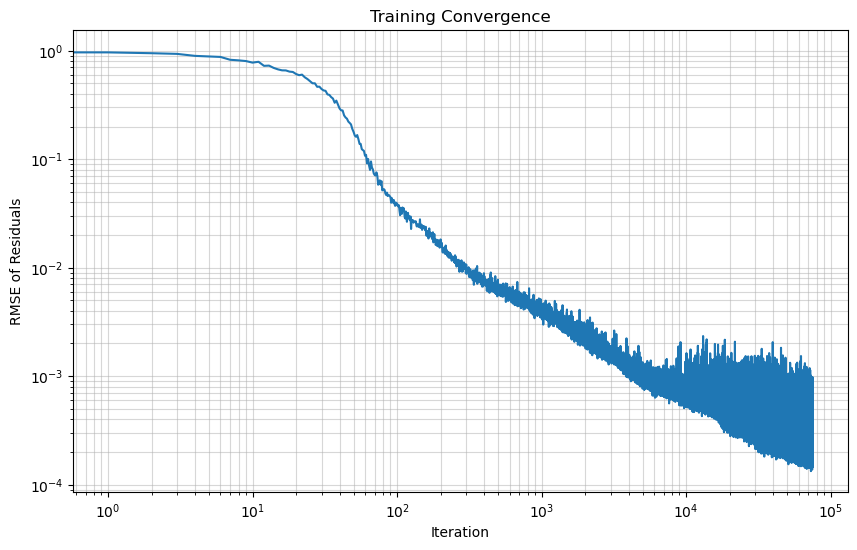

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(np.abs(results)))  # abs() for numerical safety
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Residuals')
plt.title('Training Convergence')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

In [17]:
euler_residuals(torch.tensor([4], device=device), torch.tensor([K_ss], device=device))

tensor([-0.6517], grad_fn=<SubBackward0>)

In [18]:
print(policy_function(torch.tensor([1], device=device), torch.tensor([K_ss], device=device)) )
print(savings_rate_ss)

tensor([0.6975], grad_fn=<ClampBackward1>)
0.6976744186046512


## Learned Decision Rule

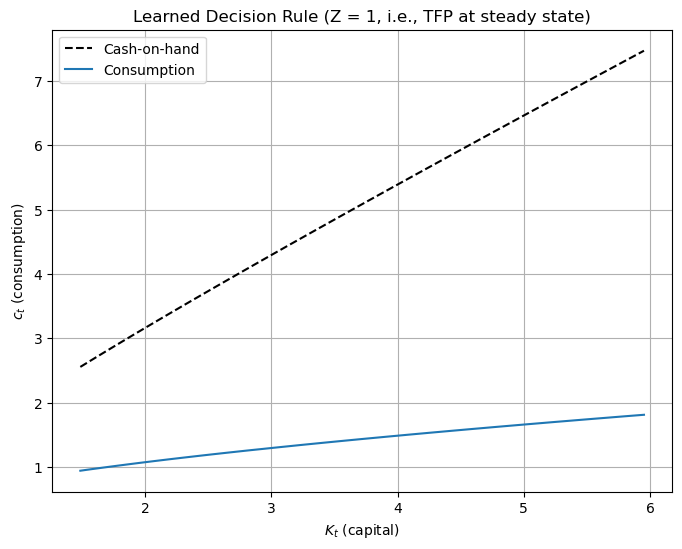

In [19]:
with torch.no_grad():
    Kvec = torch.linspace(Kmin, Kmax, 100, device=device)
    ones = torch.ones_like(Kvec)  # Z = 1 (level value at steady state)
    savings_rate_vec = policy_function(ones, Kvec)
    consumption_vec = c_fun(savings_rate_vec, ones, Kvec)
    coh_vec = coh_fun(ones, Kvec)

plt.figure(figsize=(8, 6))
plt.title("Learned Decision Rule (Z = 1, i.e., TFP at steady state)")
plt.plot(Kvec.cpu(), coh_vec.cpu(), linestyle='--', color='black', label='Cash-on-hand')
plt.plot(Kvec.cpu(), consumption_vec.cpu(), label='Consumption')
plt.xlabel("$K_t$ (capital)")
plt.ylabel("$c_t$ (consumption)")
plt.legend()
plt.grid()
plt.show()

In [20]:
from vfi_rbc_solution import vfi, extract_policies, K_grid

_, policy_K = vfi(tol = 1e-6, max_iter = 1000, verbose = True)
policy_C, policy_s = extract_policies(policy_K)

Iteration 1: max value function diff = 0.39797451
Iteration 2: max value function diff = 0.13327862
Iteration 3: max value function diff = 0.07890557
Iteration 4: max value function diff = 0.06698083
Iteration 5: max value function diff = 0.05710658
Iteration 6: max value function diff = 0.04886848
Iteration 7: max value function diff = 0.04195556
Iteration 8: max value function diff = 0.03612465
Iteration 9: max value function diff = 0.03118450
Iteration 10: max value function diff = 0.02698409
Iteration 11: max value function diff = 0.02339918
Iteration 12: max value function diff = 0.02033097
Iteration 13: max value function diff = 0.01769783
Iteration 14: max value function diff = 0.01543221
Iteration 15: max value function diff = 0.01347840
Iteration 16: max value function diff = 0.01179072
Iteration 17: max value function diff = 0.01032947
Iteration 18: max value function diff = 0.00906203
Iteration 19: max value function diff = 0.00796122
Iteration 20: max value function diff = 

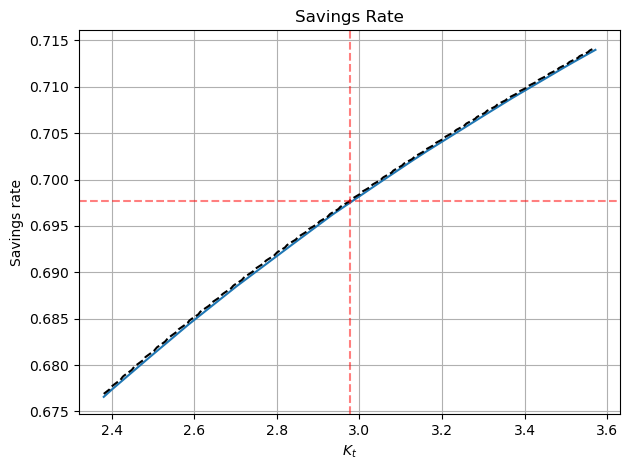

In [21]:
with torch.no_grad():
    Kvec = torch.tensor(K_grid, dtype=torch.float32, device=device)
    ones = torch.ones_like(Kvec)  # Z = 1 (level value at steady state)
    savings_rate_vec = policy_function(ones, Kvec)


plt.plot(Kvec.cpu(), savings_rate_vec.cpu())
plt.plot(Kvec.cpu(), policy_s[4, :], linestyle='--', color='black', label='VFI Solution')
plt.axvline(x=K_ss, linestyle='--', color='red', alpha=0.5)
plt.axhline(y=savings_rate_ss, linestyle='--', color='red', alpha=0.5)
plt.xlabel("$K_t$")
plt.ylabel("Savings rate")
plt.title("Savings Rate")
plt.grid()

plt.tight_layout()
plt.show()

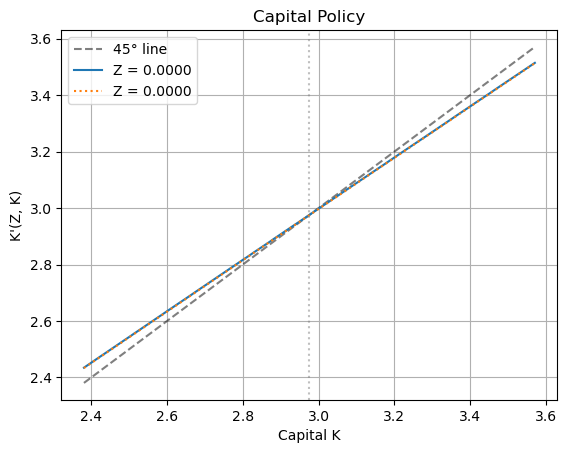

In [30]:
coh = coh_fun(ones, Kvec)
K_next_dl = savings_rate_vec * coh
K_next_vfi = policy_s * coh.cpu().numpy()
plt.plot(Kvec.cpu(), Kvec.cpu(), 'k--', alpha=0.5, label='45° line')
plt.plot(Kvec.cpu(), K_next_vfi[4,:], label=f'Z = {0:.4f}')
plt.plot(Kvec.cpu(), K_next_dl.cpu(), label=f'Z = {0:.4f}', linestyle = ':')
plt.axvline(x=K_ss, linestyle=':', color='gray', alpha=0.5)
plt.xlabel('Capital K')
plt.ylabel("K'(Z, K)")
plt.title('Capital Policy')
plt.legend()
plt.grid()
plt.show()